<a href="https://colab.research.google.com/github/rafarodriguero/ciencias_dados_python/blob/main/Simula%C3%A7%C3%A3o_Monte_Carlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
pip install --upgrade pandas-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [51]:
pip install --upgrade pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [52]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [53]:
pip install fix_yahoo_finance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Simulação de Monte Carlo
---
*   Criada durante a segunda guerra mundial
*   Nomeado em homenagem a cidade de Mônaco com seus cassinos.
* Foi criado originalmente para testar cenários do jogo paciência.
* Usada para estimar os possíveis resultados de um evento incerto, o Acaso é principal elemento da abordagem na modelagem.
  * No mercado financeiro, existem tantos cenários, que a projeção de retorno não podem ser resolvidas por uma simples analise combinatória. É preciso resolver o problema utilizando força bruta: simular o cenário N vezes, criando uma amostra e, partir da amostra, praticar a inferência estatística.



#Problema a ser resolvido
---
* Tenho uma carteira com 10 ações. Dado a dstribuição dos retornos dessa carteira no último ano:
  * Qual o máximo que eu posso perder nos próximos 3 anos, com uma confiança de 95%?
  * Qual a probabilidade de e obter lucro?

#Resolução:
* Vamos simular 10 mil cenários da carteira com 5 ações nos próximos 3 anos e criar uma distribuição de retornos com os cenários. Para isso, vamos utilizar Monte Carlo. 

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
from pandas_datareader import data as pdr
from numpy import linalg as LA

In [55]:
lista_acoes = ['WEGE3','PCAR3','LREN3','PETR4','VALE3']
#lista_acoes = ['WEGE3', 'PCAR3']
lista_acoes = [acao +".SA" for acao in lista_acoes]

data_final = dt.datetime.now()

data_inicial = data_final - dt.timedelta(days=365)



In [56]:
precos = pdr.get_data_yahoo(lista_acoes, data_inicial, data_final)['Adj Close']

precos

Symbols,WEGE3.SA,PCAR3.SA,LREN3.SA,PETR4.SA,VALE3.SA
Date,,,,,
2021-09-13,38.274792,27.350870,33.062695,15.595886,78.591347
2021-09-14,38.747074,27.537733,33.249489,15.387782,78.035667
2021-09-15,39.199680,27.045988,32.724682,15.655346,76.086647
2021-09-16,39.258720,26.416555,33.133854,15.518591,72.926743
2021-09-17,38.560127,26.062498,32.511204,14.822930,71.450447
...,...,...,...,...,...
2022-09-05,30.900000,23.700001,26.969999,33.340000,65.220001
2022-09-06,30.290001,22.730000,26.030001,32.099998,63.669998
2022-09-08,30.209999,22.000000,26.020000,31.799999,64.510002


In [57]:
retornos = precos.pct_change().dropna()
matriz_covariancia = retornos.cov()
pesos_carteira = np.full(len(lista_acoes), 1/len(lista_acoes))
numero_acoes = len(lista_acoes)

media_retornos

Symbols
IRBR3.SA   -0.005304
ECOR3.SA   -0.001218
VIIA3.SA   -0.002949
NTCO3.SA   -0.003536
PETZ3.SA   -0.002902
dtype: float64

#Fórmula retornos sintéticos
---
Retornos_sintéticos = media_retornos + Rpdf * L

* média_retornos = Média dos retornos.
* Rpdf = Matriz aleatória gerada por alguma função de densidade de probabilidade.
* L = Matriz triangular inferios proveniente de uma decomposição de Cholesky, usando como base a matriz de convariância dos dados originais.

# Por que fazer isso?
---
Nós assumimos que a distribuição de retornos é uma distribuição normal multivariada(isso é uma expansão da distribuição normal).
Quando geramos retornos aleatórios de cada ativo, nós criamos vetores aleatórios descorrelacionados entre si. Para corrigir isso, precisamos correlacionar esses retornos (no mundo real isso é o que acontece) e, para isso, usamos a matriz triângular obtida a partir da convariância.

In [58]:
#premissas monetária

numero_simulacoes = 10000

dias_projetados = 252 * 3

capital_inicial = 1000

In [59]:
#gerando retornos médio

retorno_medio = retornos.mean(axis=0).to_numpy()
matriz_retorno_medio = retorno_medio * np.ones(shape = (dias_projetados, numero_acoes))

In [60]:
#gerando L

L = LA.cholesky(matriz_covariancia)
L

array([[ 0.02236478,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.00660502,  0.02780808,  0.        ,  0.        ,  0.        ],
       [ 0.00884793,  0.00704757,  0.02432084,  0.        ,  0.        ],
       [ 0.00362614,  0.00414963,  0.00329851,  0.02255762,  0.        ],
       [ 0.00306749,  0.00294982, -0.00234223,  0.0068645 ,  0.02319851]])

In [61]:
#gerando simulações

retornos_carteira = np.zeros([dias_projetados, numero_simulacoes]) #cada coluna é uma simulação
montante_final = np.zeros(numero_simulacoes)

for s in range(numero_simulacoes):

  Rpdf = np.random.normal(size=(dias_projetados, numero_acoes))

  retornos_sinteticos = matriz_retorno_medio + np.inner(Rpdf, L) #única coisa random é o Rpdf

  retornos_carteira[:, s] = np.cumprod(np.inner(pesos_carteira, retornos_sinteticos) +1) * capital_inicial
  montante_final[s] = retornos_carteira[-1, s]

retornos_carteira

array([[ 995.86254556, 1004.93032557, 1010.43134215, ...,  982.04242579,
        1004.50728549,  980.99410108],
       [ 993.33638456, 1021.42292564, 1000.96642246, ...,  981.31660374,
        1025.30861666, 1004.78498275],
       [ 993.4871281 , 1004.54026458,  997.21239203, ...,  984.42929061,
        1009.97029161, 1008.9718338 ],
       ...,
       [1726.59553132, 1066.42630097, 1225.84889364, ..., 1931.0640845 ,
        3329.90427931, 1748.60442334],
       [1744.2097105 , 1052.3340135 , 1183.36021858, ..., 1891.85385775,
        3382.16335711, 1705.6660523 ],
       [1756.70752483, 1041.28233576, 1153.94955077, ..., 1874.99460965,
        3390.06235258, 1649.21106254]])

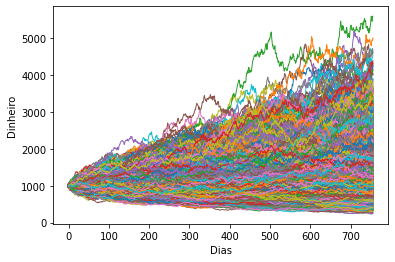

In [62]:
plt.plot(retornos_carteira, linewidth=1)
plt.ylabel('Dinheiro')
plt.xlabel('Dias')
plt.show()

In [65]:
montante_99 = str(np.percentile(montante_final, 1))
montante_95 = str(np.percentile(montante_final, 5))
montante_mediano = str(np.percentile(montante_final, 50))

cenario_com_lucro = str((len(montante_final[montante_final > capital_inicial]) / len(montante_final)) * 100) + "%"

In [66]:
print(f'''Ao investir R$ {capital_inicial} na carteira {lista_acoes}, 
      podemos esperar esses resultados para os próximos {dias_projetados} dias, 
      utilizando o método de Monte Carlo com {numero_simulacoes} simulações:
      
      Com 50% de probabilidade o montante será maior que R$ {montante_mediano},
      
      Com 95% de probabilidade o montante será maior que R$ {montante_95},
      
      Com 99% de probabilidade o montante será maior que R$ {montante_99}, 
      
      Em {cenario_com_lucro} dos cenários, foi possível obter lucro nos próximos {dias_projetados} dias.''')

Ao investir R$ 1000 na carteira ['WEGE3.SA', 'PCAR3.SA', 'LREN3.SA', 'PETR4.SA', 'VALE3.SA'], 
      podemos esperar esses resultados para os próximos 756 dias, 
      utilizando o método de Monte Carlo com 10000 simulações:
      
      Com 50% de probabilidade o montante será maior que R$ 1183.4486253792763,
      
      Com 95% de probabilidade o montante será maior que R$ 604.1299615389191,
      
      Com 99% de probabilidade o montante será maior que R$ 447.26525014006864, 
      
      Em 65.22% dos cenários, foi possível obter lucro nos próximos 756 dias.


#Utilidades
---
A partir dessas métricas, é possível calcular coisas como o VAR da carteira para diferentes intervalos de confiança e medir se o risco que você está correndo é compatível com o  que você aguenta perder. No caso dessa carteira, uma queda de xxx% está dentro dos 95% dos cenários mais possíveis de acontecer nos próximos 3 anos.

TypeError: ignored

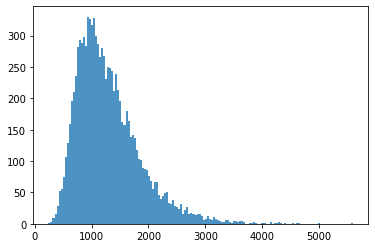

In [67]:
config = dict(histtype = "stepfilled", alpha = 0.8, density = False, bins = 150)
fig, ax = plt.subplots()
ax.hist(montante_final, **config)
ax.xaxis.set_major_formatter('R${x:.0f}')
plt.title("Distribuição montantes finais com simulação MC")
plt.ylabel("Frequência")
plt.show()